In [ ]:
# %%

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import ttest_1samp, ttest_ind
from scipy.stats import pearsonr

from dieboldmariano import dm_test


def warn(*args, **kwargs):
    pass


warnings.warn = warn

In [ ]:
# %%

tick = "1d"

df_bars = pd.read_csv(
    f"../data/ohlc_{tick}_gateio.csv", index_col=0, parse_dates=True)
df_close = df_bars.filter(axis="columns", like="close")
df_close.columns = [x.split("_")[0] for x in df_close.columns]

tick = "24h"
df_close = df_close.resample(tick).last()

In [ ]:
# %%

n_train_days = 120
df_ica_pred = pd.read_csv(
    f"../data/ica_arma_predictions_{tick}_{n_train_days}D.csv",
    index_col=0,
    parse_dates=True)

df_arima_pred = pd.read_csv(
    f"../data/arma_predictions_{tick}_{n_train_days}D.csv",
    index_col=0,
    parse_dates=True)

df_pca_pred = pd.read_csv(
    f"../data/pca_arma_predictions_{tick}_{n_train_days}D.csv",
    index_col=0,
    parse_dates=True)#.shift(-1).dropna()

df_ret = df_close.pct_change().fillna(0).loc[df_pca_pred.index, df_pca_pred.columns].unstack()

df_pca_pred = df_pca_pred.iloc[:-1].unstack()
df_ica_pred = df_ica_pred.iloc[1:].unstack()
df_arima_pred = df_arima_pred.unstack()

df_ret = df_ret.reindex(df_ica_pred.index)

# scale ica preds with scalar
df_ica_pred *= df_pca_pred.var() / df_ica_pred.var()

In [ ]:
#%%

#naive_forecast = df_ret.reset_index().sample(frac=1.0, replace=True)[0].to_frame().set_index(df_ret.index)[0]
naive_forecast = df_ret.shift().fillna(0)

# %% [markdown]

  # Empirical Results
  ## R (Pearson Correlation)
 - **Pearson Correlation** of ica_arima **better** than just arima

In [ ]:
# %%

pearsonr(df_ret, df_ica_pred, alternative="greater"), \
    pearsonr(df_ret, df_pca_pred, alternative="greater"), \
        pearsonr(df_ret, naive_forecast, alternative="greater")

(PearsonRResult(statistic=0.012862153541873964, pvalue=0.0711120828233069),
 PearsonRResult(statistic=0.029717405436614178, pvalue=0.00034776602979055165),
 PearsonRResult(statistic=-0.03729243853196822, pvalue=0.9999896096720782))

# %% [markdown]

 ## Directional accuracy
 - Diebold Mariano test shows **Directional Accuarcy** (correct sign of returns predicted) for ica_arima significantly **better** than arima

In [ ]:
#%%

print("Diebold Mariano test statistic, p-value:",
dm_test(
    np.sign(df_ret).values,
    np.sign(df_ica_pred).values,
    np.sign(df_pca_pred).values,
    loss=lambda a, b: abs(a - b),
    one_sided=True))

Diebold Mariano test statistic, p-value: (-1.5766232830513518, 0.05745326445920368)


# %% [markdown]

 ## Mean Absolute Error
 - Diebold Mariano test shows **Mean Absolute Error** of ica_arima predicitons significantly **better** than arima

In [ ]:
#%%

print("Diebold Mariano test statistic, p-value:",
dm_test(
    df_ret.values,
    df_ica_pred.values,
    df_pca_pred.values,
    loss=lambda a, b: abs(a - b),
    one_sided=True))

Diebold Mariano test statistic, p-value: (-9.967741600362901, 1.2786319782669299e-23)


# %% [markdown]

 ## Mean Squared Error
 - Diebold Mariano test shows **Mean Squared Error** of ica_arima predicitons significantly **better** than arima

In [ ]:
#%%

print("Diebold Mariano test statistic, p-value:",
dm_test(
    df_ret.values,
    df_ica_pred.values,
    df_pca_pred.values,
    loss=lambda a, b: (a - b)**2,
    one_sided=True))

Diebold Mariano test statistic, p-value: (-3.797172425808174, 7.351027632845069e-05)


# %% [markdown]

 ## Comaparison of ARIMA orders
 - for just ARIMA the AutoARIMA algorithm determined Brownian Noise with order (0, 1, 0) to be the best model of the process
 way more often than for ica + ARIMA, indicating application of ICA improved the Signal to Noise Ratio

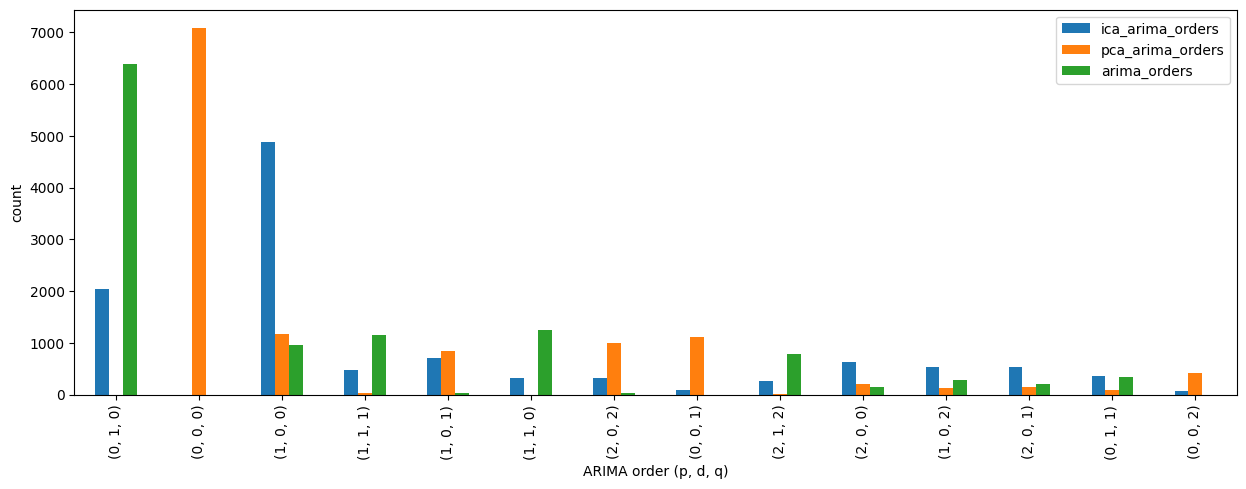

In [ ]:
#%%

n_train_days = 120
tick = "24h"
ica_orders = pd.read_csv(f"../data/ica_arma_orders_{tick}_{n_train_days}D.csv", index_col=0)
pca_arima_orders = pd.read_csv(f"../data/pca_arma_orders_{tick}_{n_train_days}D.csv", index_col=0)
arima_orders = pd.read_csv(f"../data/arma_orders_{tick}_{n_train_days}D.csv", index_col=0)
orders = pd.concat((
    ica_orders.unstack().value_counts().rename("ica_arima_orders"),
    pca_arima_orders.unstack().value_counts().rename("pca_arima_orders"),
    arima_orders.unstack().value_counts().rename("arima_orders")
    ), axis=1, join="outer")

orders.iloc[np.argsort(orders.sum(axis=1))[:-15:-1]].plot.bar(figsize=(15, 5))
#orders.iloc[np.argsort(orders["arima_orders"].values)[:-30:-1]].plot.bar(figsize=(15, 5))
#orders.iloc[np.argsort(orders.sum(axis=1))[::-1]].plot.bar(figsize=(15, 5))
plt.xlabel("ARIMA order (p, d, q)")
plt.ylabel("count")
plt.show();

In [ ]:
#%%

ttest_ind(
    (np.sign(df_ret) == np.sign(df_ica_pred)),
    (np.sign(df_ret) == np.sign(df_pca_pred)),
    alternative="greater")

Ttest_indResult(statistic=1.6492074474976353, pvalue=0.04955860293310294)

In [ ]:
#%%

ttest_ind(
    ((df_ret - df_ica_pred)**2).values,
    ((df_ret - df_pca_pred)**2).values,
    alternative="less")

Ttest_indResult(statistic=-0.09546797875449688, pvalue=0.461971928989915)

In [ ]:
#%%

ttest_ind(
    (df_ica_pred - df_ret).abs().values, 
    (df_pca_pred - df_ret).abs().values,
    alternative="less")

Ttest_indResult(statistic=-1.8355327323098922, pvalue=0.03321909589210676)